In [ ]:
# Test the ability of a model trained on Dataset 1 to generalize to Dataset 2
# Negative class (0) Non-cyberbullying/Non-hatespeech
# Positive class (1) Cyberbullying/Hatespeech

In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from pathlib import Path
import json
import random
import sys
sys.path.append('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\src')
from utils.results import create_results_file, append_results_to_json
from utils.data import balance_train_and_test
from catboost import CatBoostClassifier

from progress.bar import Bar


In [2]:
RANDOM_SEED = 115
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
CLEAN_DATA_PATH = Path("../data/en_only")
EXPERIMENTS_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments')
RESULT_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments\\results\\exp1')

In [4]:
TRAIN_DATA_NAME = '48000_cyberbullying_tweets_basic_clean.csv' 
TEST_DATA_NAME = 'hatespeech_tweets_basic_clean.csv'

In [5]:
train_data = CLEAN_DATA_PATH / TRAIN_DATA_NAME
test_data = CLEAN_DATA_PATH / TEST_DATA_NAME

### Test 1 
- Consider offensive tweets to be bullying tweets

In [63]:
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

In [64]:
train_df.dropna(inplace=True)
train_df['label'].value_counts()

label
religion     7942
age          7910
gender       7396
ethnicity    7319
other        6731
notcb        6377
Name: count, dtype: int64

In [65]:
test_df.dropna(inplace=True)
print(f'Test DF: {test_df["class"].value_counts()}\n')

# Drop hatespeech tweets from test_df
test_df = test_df[test_df["class"] != 0]
print(f'Test DF: {test_df["class"].value_counts()}')

Test DF: class
1    17476
2     3786
0     1246
Name: count, dtype: int64

Test DF: class
1    17476
2     3786
Name: count, dtype: int64


In [66]:
# calculate the percentage of cyberbullying tweets in the train set
total_cb = train_df[train_df['label'] != 'notcb'].shape[0]
total_cb / train_df.shape[0]

0.8539896966227819

In [67]:
# calculate the percentage of offensive tweets in the test set
test_df[test_df["class"] == 1].shape[0] / test_df.shape[0]

0.8219358479917224

In [68]:
label2id = {'notcb': 0, 'cb': 1}
id2label = {0: 'notcb', 1: 'cb'}

In [76]:
train_df['label'] = train_df['label'].apply(lambda label : 0 if label == 'notcb' else 1)

In [77]:
test_df['class'] = test_df['class'].apply(lambda label : 0 if label == 2 else 1) # originally, offensive = 1, non-offensive = 2 

In [78]:
ratio = train_df[train_df["label"] == 0].shape[0] / train_df[train_df["label"] == 1].shape[0]
ratio

0.17097431497667434

In [175]:
x_train, y_train = train_df['tweet'], train_df['label']
x_test, y_test = test_df['tweet'], test_df['class']

In [ ]:
vect = CountVectorizer()
vect.fit_transform(x_train)
feature_names = 

In [ ]:
def count_oov_words(text, vocabulary):
    words = text.split()
    return sum(1 for word in words if word not in vocabulary)

# Filter the test set
filtered_test_texts = []
filtered_test_vectors = []

for text, vector in zip(test_texts, test_vectors):
    oov_count = count_oov_words(text, feature_names)
    if oov_count <= 3:
        filtered_test_texts.append(text)
        filtered_test_vectors.append(vector)

In [80]:
nan_rows_train = train_df[train_df.isna().any(axis=1)]
nan_rows_test = test_df[test_df.isna().any(axis=1)]
print(len(nan_rows_train))
print(len(nan_rows_test))

0
0


In [176]:
# feature extraction
vect = CountVectorizer()
x_train = vect.fit_transform(x_train)
vect2 = CountVectorizer()
x_test = vect2.fit_transform(x_test)

# calculate the number of OOV features in the test set
feats_train = vect.get_feature_names_out()
feats_test = vect2.get_feature_names_out()
oov_feats = np.setdiff1d(feats_test, feats_train)
print(f'Number of OOV features: {len(oov_feats)}')
print(f'OOV features: {oov_feats}')


Number of OOV features: 8614
OOV features: ['02' '0300' '08' ... 'zulema' 'zulu' 'zzzquil']


In [169]:
len(feats_test)


20348

In [82]:
m = xgb.XGBClassifier(random_state=RANDOM_SEED, scale_pos_weight=ratio)
m.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=115, ...)

In [83]:
preds = m.predict(x_test)
print(classification_report(y_test, preds, target_names=['notcb', 'cb']))

              precision    recall  f1-score   support

       notcb       0.34      0.94      0.50      3786
          cb       0.98      0.61      0.75     17476

    accuracy                           0.67     21262
   macro avg       0.66      0.77      0.63     21262
weighted avg       0.86      0.67      0.71     21262



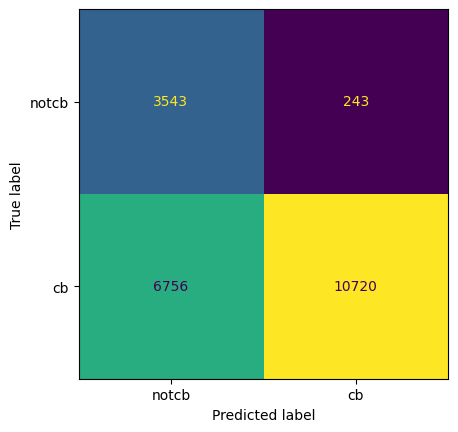

In [85]:
ConfusionMatrixDisplay.from_estimator(m, x_test, y_test, display_labels=['notcb', 'cb'], colorbar=False)

In [86]:
m = CatBoostClassifier(random_state=RANDOM_SEED, logging_level='Silent', class_weights=[1, ratio])
m.fit(x_train, y_train)

In [ ]:
preds = m.predict(x_test)

### Test 2
- Consider hate speech to be bullying tweets

In [7]:
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

# remove duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
# remove rows with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

In [216]:
total_cb = train_df[train_df['label'] != 'notcb'].shape[0]
print(total_cb)


37298


In [8]:
# add offensive rows and neither rows to the train_df
# Add offensive rows to the train_df
offensive_data = test_df[test_df['class'] == 1]
neither_rows = test_df[test_df['class'] == 2]
hatespeech_data = test_df[test_df['class'] == 0]

non_cb_data = pd.concat([offensive_data, neither_rows])

In [9]:
# convert all cyberbullying tweets to cb
train_df['label'] = train_df['label'].apply(
    lambda label : 'notcb' if label == 'notcb' else 'cb'
)

In [10]:
# Balance the ratio of cb to non-cb for both datasets
# calculate the number of noncb tweets to move from the test set so that the ratio of cb to non-cbset

x1 = non_cb_data.shape[0] # num of non-cb tweets in the test set
y1 = train_df[train_df['label'] == 'notcb'].shape[0] # num of non-cb tweets in the train set
x2_hat = hatespeech_data.shape[0] # num of cb in test set
y2_hat = train_df[train_df['label'] == 'cb'].shape[0] # num of cb tweets in the train set
x12 = None # num of non-cb tweets to move from the test set to the train set

x12 = (y2_hat * x1 - x2_hat * y1) / (y2_hat + x2_hat) 
print(x12)

20368.522571606474


In [30]:
# check
np.testing.assert_allclose(ratio:=(y1 + x12)/(y2_hat), (x1 - x12)/(x2_hat), atol=1e-5)
ratio # ratio of non-cb to cb data

0.7170765877957659

In [12]:
non_cb_data = non_cb_data.sample(frac=1, random_state=RANDOM_SEED)
data_to_move = non_cb_data.iloc[:int(x12)]
data_to_move = data_to_move.rename(columns={'class': 'label'})
data_to_move['label'] = 'notcb'
train_df = pd.concat([train_df, data_to_move])
test_df = pd.concat([hatespeech_data, non_cb_data.iloc[int(x12):]])

In [13]:
print(f'Train DF:\n{train_df["label"].value_counts()} \n')
print(f"Test DF:\n{test_df['class'].value_counts()}")

Train DF:
label
cb       37298
notcb    26745
Name: count, dtype: int64 

Test DF:
class
0    1246
1     744
2     150
Name: count, dtype: int64


In [17]:
# 0 is the positive class
# 1 is the negative class
train_df['label'] = train_df['label'].apply(lambda label : 0 if label == 'cb' else 1)
test_df['class'] = test_df['class'].apply(lambda label : 0 if label == 0 else 1)

In [18]:
test_df['class'].value_counts()[1] / test_df['class'].shape[0]

0.4177570093457944

In [21]:
VECTS = [
    CountVectorizer(),
    TfidfVectorizer(),
    CountVectorizer(ngram_range=(1, 2)),
    TfidfVectorizer(ngram_range=(1, 2)),
]

In [26]:
create_results_file(RESULT_PATH / 'exp3_1.json')

for vect in VECTS:
    x_train, y_train = train_df['tweet'], train_df['label']
    x_test, y_test = test_df['tweet'], test_df['class']
    x_train = vect.fit_transform(x_train)
    x_test = vect.transform(x_test)
    m = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_SEED, scale_pos_weight=(ratio))
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    print(result:=classification_report(y_test, preds, target_names=['cb', 'notcb'], output_dict=True))
    result['model_name'] = vect.__class__.__name__
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_params().items()}
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_1.json')


{'cb': {'precision': 0.8257142857142857, 'recall': 0.2319422150882825, 'f1-score': 0.36215538847117795, 'support': 1246.0}, 'notcb': {'precision': 0.4653631284916201, 'recall': 0.9317673378076062, 'f1-score': 0.620715350223547, 'support': 894.0}, 'accuracy': 0.5242990654205607, 'macro avg': {'precision': 0.6455387071029529, 'recall': 0.5818547764479444, 'f1-score': 0.4914353693473624, 'support': 2140.0}, 'weighted avg': {'precision': 0.6751750639586488, 'recall': 0.5242990654205607, 'f1-score': 0.47017062482941063, 'support': 2140.0}}
{'cb': {'precision': 0.8381962864721485, 'recall': 0.2536115569823435, 'f1-score': 0.3894023413431916, 'support': 1246.0}, 'notcb': {'precision': 0.47249007373794666, 'recall': 0.9317673378076062, 'f1-score': 0.6270229582235604, 'support': 894.0}, 'accuracy': 0.5369158878504673, 'macro avg': {'precision': 0.6553431801050476, 'recall': 0.5926894473949749, 'f1-score': 0.508212649783376, 'support': 2140.0}, 'weighted avg': {'precision': 0.6854199527411314, '

In [29]:
for vect in VECTS:
    x_train, y_train = train_df['tweet'], train_df['label']
    x_test, y_test = test_df['tweet'], test_df['class']
    x_train = vect.fit_transform(x_train)
    x_test = vect.transform(x_test)
    m = CatBoostClassifier(random_state=RANDOM_SEED, logging_level='Silent', class_weights=[ratio, 1])
    m.fit(x_train, y_train)
    preds = m.predict(x_test)
    print(result:=classification_report(y_test, preds, target_names=['cb', 'notcb'], output_dict=True))
    result['model_name'] = "CatBoostClassifier"
    result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_params().items()}
    result['vectorizer_name'] = vect.__class__.__name__
    result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
    append_results_to_json(result, RESULT_PATH / 'exp3_1.json')

{'cb': {'precision': 0.9078014184397163, 'recall': 0.10272873194221509, 'f1-score': 0.18457101658255226, 'support': 1246.0}, 'notcb': {'precision': 0.44072036018009003, 'recall': 0.9854586129753915, 'f1-score': 0.6090563428966471, 'support': 894.0}, 'accuracy': 0.47149532710280373, 'macro avg': {'precision': 0.6742608893099031, 'recall': 0.5440936724588032, 'f1-score': 0.3968136797395997, 'support': 2140.0}, 'weighted avg': {'precision': 0.7126750324191061, 'recall': 0.47149532710280373, 'f1-score': 0.36190273701470216, 'support': 2140.0}}
{'cb': {'precision': 0.9020979020979021, 'recall': 0.10353130016051364, 'f1-score': 0.1857451403887689, 'support': 1246.0}, 'notcb': {'precision': 0.44066099148723087, 'recall': 0.9843400447427293, 'f1-score': 0.6087858872362504, 'support': 894.0}, 'accuracy': 0.47149532710280373, 'macro avg': {'precision': 0.6713794467925664, 'recall': 0.5439356724516214, 'f1-score': 0.39726551381250963, 'support': 2140.0}, 'weighted avg': {'precision': 0.7093293983